In [0]:
%tensorflow_version 2.x

In [0]:
import os
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

**Загрузка KTH Action recognition dataset**

In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip    
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip    
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip    
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip    

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null    
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null                

--2020-05-07 13:04:44--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-05-07 13:04:44--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [     <=>            ] 231.21M  8.32MB/s    in 31s     

2020-05-07 13:05:16 (7.58 MB/s) - ‘walking.zip’ saved [242442411]

--2020-05-07 13:05:17--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

**Список «ссылка на .avi» / «метка класса»:**

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping'
]

data_list = []
data_root = './'

for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        data_list.append((fpath, cls_idx))


Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


**Выделим из списка 200 пар для обучения посредством функции *train_test_split*:**

In [0]:
SUBSET_LEN = 200

random.shuffle(data_list)
data_array = np.array(data_list)
train_x, valid_x, train_y, valid_y = train_test_split(data_array[:, 0],
                                                      data_array[:, 1],
                                                      train_size=SUBSET_LEN, random_state=21,
                                                      stratify=data_array[:, 1])

assert SUBSET_LEN == len(train_x)

## Обучение модели

**Нейронная сеть из видеоурока:**

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
])

**Параметры для обучения и компиляция модели:**

In [0]:
BATCH_SIZE = 3
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

**Создание обучающего датасета**

Чтобы иметь возможность делать батчи, ограничиваем длину всех считываемых видео до 200 кадров - и берём их из середины каждого ролика.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

def fpath_to_video(fpath):
    fpath = fpath.numpy().decode('utf-8')
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    # возвращаем 200 кадров из середины считанного ролика
    return videodata[len(videodata)//2-100:len(videodata)//2+1+100, ...]

dataset = dataset.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                            tf.numpy_function(np.int8, [label], tf.int8)))
dataset = dataset.shuffle(buffer_size=SUBSET_LEN)
dataset = dataset.batch(BATCH_SIZE)

**Процесс обучения:**

In [9]:
%%time
global_step = 0
losses = []
for ep in range(NUM_EPOCHS):
    for i, (videodata, labels) in enumerate(dataset):
        loss_value = model.train_on_batch(videodata, labels)

        if i % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{i}/{SUBSET_LEN}] Loss: {loss_value}')
            losses.append([loss_value, global_step])
               
        global_step += 1

[0/10][0/200] Loss: 1.7902698516845703
[0/10][10/200] Loss: 1.9430376291275024
[0/10][20/200] Loss: 1.7973089218139648
[0/10][30/200] Loss: 1.7907323837280273
[0/10][40/200] Loss: 1.7907003164291382
[0/10][50/200] Loss: 1.791446328163147
[0/10][60/200] Loss: 1.7935060262680054
[1/10][0/200] Loss: 1.7909599542617798
[1/10][10/200] Loss: 1.7908669710159302
[1/10][20/200] Loss: 1.7890005111694336
[1/10][30/200] Loss: 1.7925087213516235
[1/10][40/200] Loss: 1.7933197021484375
[1/10][50/200] Loss: 1.7916005849838257
[1/10][60/200] Loss: 1.7906824350357056
[2/10][0/200] Loss: 1.7893762588500977
[2/10][10/200] Loss: 1.7800790071487427
[2/10][20/200] Loss: 1.77924644947052
[2/10][30/200] Loss: 1.74394690990448
[2/10][40/200] Loss: 1.5528064966201782
[2/10][50/200] Loss: 1.7065542936325073
[2/10][60/200] Loss: 1.691969394683838
[3/10][0/200] Loss: 1.5941380262374878
[3/10][10/200] Loss: 1.4560264348983765
[3/10][20/200] Loss: 1.4273642301559448
[3/10][30/200] Loss: 1.1452441215515137
[3/10][40/

**График значений функции потерь в процессе обучения сети**

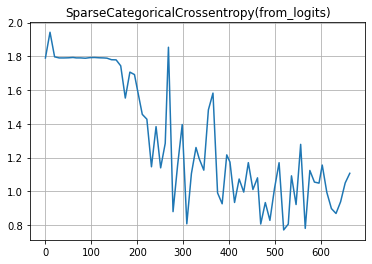

In [21]:
losses_array = np.array(losses)
plt.plot(losses_array[:, 1], losses_array[:, 0])
plt.title('SparseCategoricalCrossentropy(from_logits)')
plt.grid(True)
plt.show()

**Сохранение модели**

In [0]:
model.save('/content/drive/My Drive/video_model.h5')

## Проверка работы модели

In [0]:
def make_random_predict():
    fpath, cls_true = random.choice(data_list)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    plt.imshow(videodata[42, ...])
    plt.axis('off'); plt.show()

    videodata = videodata[len(videodata)//2-100:len(videodata)//2+1+100, ...]

    out = model(videodata[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[cls_true])
    print('Pred class:', classes[cls_pred])  

**Правильный ответ**

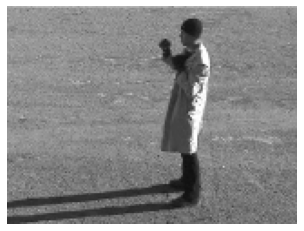

True class: boxing
Pred class: boxing


In [19]:
make_random_predict()

**Неправильный ответ**

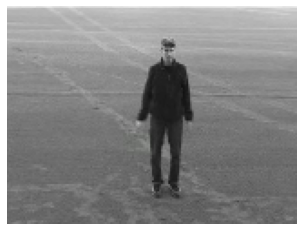

True class: handwaving
Pred class: handclapping


In [23]:
make_random_predict()

Как можно улучшить результат:
    - взять больше файлов для обучения и больше эпох;
    - изменить модель - в частности добавить батч-нормализацию и регуяризаторы;
    - найти способ возвращать видео длиною более 200 кадров - с дополнением, если не хватает.